In [125]:
import glob

import imageio.v3 as iio
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split


torch.manual_seed(0)
np.random.seed(0)

In [126]:
device = "cuda" if torch.cuda.is_available() else "cpu"

seconds = 12.8
seconds_per_pixel = 0.1
num_sequence = 10
COMPOSERS = ["Bach", "Beethoven", "Chopin", "Mozart"]
image_dir = "data/new_images"

In [127]:
def slice_image(image, seconds, seconds_per_pixel):
    pix_per_slice = int(seconds // seconds_per_pixel)
    num_slices = int(image.shape[1] // pix_per_slice)

    slices = np.zeros((num_slices, image.shape[0], pix_per_slice))
    for slice in range(num_slices):
        slices[slice] = image[:, slice * pix_per_slice : (slice + 1) * pix_per_slice]

    return slices

In [128]:
def convert_song_to_inputs(song: str, composer:str, seconds:float = 12.8, seconds_per_pixel:float = 0.1, num_sequence:int = 10):
    """Returns inputs with shape [num_inputs, sequence_length, channels, image_height, image_width]"""

    pixels_per_slice = int(seconds // seconds_per_pixel)
    sequence_length = pixels_per_slice * num_sequence

    # Load image
    im = iio.imread(song, mode="L")
    image = (im > 0).astype(int)

    # Pad image
    pad_width = int(np.ceil(image.shape[1] / sequence_length) * sequence_length) - image.shape[1]
    padded_image = np.pad(image, ((0, 0), (0, pad_width)), mode='constant', constant_values=0)

    # Convert to input and output for network
    images = []
    outputs = []
    for pad_image in padded_image.T.reshape(-1, sequence_length, image.shape[0]):
        images.append(slice_image(pad_image.T, seconds, seconds_per_pixel))
        outputs.append(composer)

    # Convert to numpy array
    inputs = np.expand_dims(np.array(images), axis=2)

    return inputs, outputs

In [129]:
inputs = []
outputs = []
for composer in COMPOSERS:
    for im_path in glob.glob(image_dir + "/" + composer + "/*.png"):
        input, output = convert_song_to_inputs(im_path, composer)
        inputs.append(input)
        outputs += output

inputs = np.vstack(inputs)
inputs.shape

(6173, 10, 1, 128, 128)

In [130]:
output_df = pd.DataFrame(outputs)
output_df.value_counts()

0        
Bach         2208
Beethoven    1838
Mozart       1623
Chopin        504
Name: count, dtype: int64

In [131]:
# Get dummies
output_df = pd.get_dummies(output_df)
output_df.head()

,0_Bach,0_Beethoven,0_Chopin,0_Mozart
0,True,False,False,False
1,True,False,False,False
2,True,False,False,False
3,True,False,False,False
4,True,False,False,False


In [132]:
# Split into train, test, and validation
train_X, test_X, train_y, test_y = train_test_split(inputs, output_df, test_size=0.2)
test_X, val_X, test_y, val_y = train_test_split(test_X, test_y, test_size=0.5)

# Convert to torch tensors
train_X = torch.Tensor(train_X).to(device)
test_X = torch.Tensor(test_X).to(device)
val_X = torch.Tensor(val_X).to(device)

train_y = torch.Tensor(train_y.to_numpy().astype(int)).to(device)
test_y = torch.Tensor(test_y.to_numpy().astype(int)).to(device)
val_y = torch.Tensor(val_y.to_numpy().astype(int)).to(device)

In [133]:
# Define the model
class ComposerClassifier(nn.Module):
    def __init__(self, hidden_nodes, seconds = 12.8, seconds_per_pixel = 0.1):
        super(ComposerClassifier, self).__init__()

        # Define network parameters
        self.hidden_nodes = hidden_nodes

        # Define image slicing parameters
        self.seconds = seconds
        self.seconds_per_pixel = seconds_per_pixel

        # Define CNN layers
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(3,3))
        self.pool1 = nn.MaxPool2d(kernel_size=(3,3), stride=3)

        self.conv2 = nn.Conv2d(4, 8, kernel_size=(5,5))
        self.pool2 = nn.MaxPool2d(kernel_size=(5,5), stride=5)

        # Define LSTM layers
        self.lstm = nn.LSTM(392, self.hidden_nodes, batch_first=True)
        self.fc = nn.Linear(self.hidden_nodes, 4)


    def forward(self, x):
        # Create sequence tensor from slices processed through CNN layers
        num_inputs = x.shape[0]
        x = torch.vstack(torch.unbind(x, dim=0)).to(x.device)
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        sequence = x.reshape(num_inputs, -1, 392).to(x.device)

        # Process sequence tensor through LSTM layers
        h0 = torch.zeros(1, sequence.size(0), self.hidden_nodes).to(x.device)
        c0 = torch.zeros(1, sequence.size(0), self.hidden_nodes).to(x.device)
        out, _ = self.lstm(sequence, (h0, c0))
        out = self.fc(out[:, -1, :])

        # Return softmax probabilities
        return nn.functional.softmax(out, dim=1)

In [134]:
model = ComposerClassifier(100, seconds=seconds, seconds_per_pixel=seconds_per_pixel)
model = model.to(device)

In [135]:
# https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        # Number of epochs to wait if no improvement is seen
        self.patience = patience

        # Minimum change in the monitored quantity to qualify as an improvement
        self.min_delta = min_delta

        # Internal trackers
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        # If the validation loss has improved
        if validation_loss < self.min_validation_loss:
            # Save the best validation loss and reset the counter
            self.min_validation_loss = validation_loss
            self.counter = 0

        # If the validation loss has not improved
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            # Increment the counter and if the counter is greater than the patience, stop training
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [136]:
# Training loop
def train(model, optimizer, criterion, scheduler, train_X, train_y, val_X, val_y, num_epochs=300, batch_size=32, lr=0.001, early_stopper=None) -> tuple[list, list, list]:
    # Initialize lists to store metrics
    train_losses = []
    val_losses = []

    accuracies = []

    micro_precisions = []
    micro_recalls = []
    micro_f1s = []

    macro_precisions = []
    macro_recalls = []
    macro_f1s = []

    weighted_precisions = []
    weighted_recalls = []
    weighted_f1s = []

    # Train the model
    num_batches = int(np.ceil(len(train_X) / batch_size))
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            # Get the batch data
            batch_X = train_X[batch_size * batch:min(batch_size * (batch + 1), train_X.shape[0])]
            batch_y = train_y[batch_size * batch:min(batch_size * (batch + 1), train_X.shape[0])]

            # Forward Pass
            optimizer.zero_grad()
            output = model(batch_X)

            # Backward Pass
            train_loss = criterion(output, batch_y)
            train_loss.backward()
            optimizer.step()

        # Evaluate the model
        with torch.no_grad():
            # Forward Pass
            output = model(val_X)

            # Compute Metrics
            val_loss = criterion(output, val_y)
            correct = correct = val_y.cpu().argmax(dim=1)
            answer = output.argmax(dim=1).cpu()

            accuracy = accuracy_score(correct, answer)

            micro_precision = precision_score(correct, answer, average='micro', zero_division=0)
            micro_recall = recall_score(correct, answer, average='micro', zero_division=0)
            micro_f1 = f1_score(correct, answer, average='micro', zero_division=0)

            macro_precision = precision_score(correct, answer, average='macro', zero_division=0)
            macro_recall = recall_score(correct, answer, average='macro', zero_division=0)
            macro_f1 = f1_score(correct, answer, average='macro', zero_division=0)

            weighted_precision = precision_score(correct, answer, average='weighted', zero_division=0)
            weighted_recall = recall_score(correct, answer, average='weighted', zero_division=0)
            weighted_f1 = f1_score(correct, answer, average='weighted', zero_division=0)


            # Record Metrics
            train_losses += [train_loss.item()]
            val_losses += [val_loss.item()]

            accuracies += [accuracy]

            micro_precisions += [micro_precision]
            micro_recalls += [micro_recall]
            micro_f1s += [micro_f1]

            macro_precisions += [macro_precision]
            macro_recalls += [macro_recall]
            macro_f1s += [macro_f1]

            weighted_precisions += [weighted_precision]
            weighted_recalls += [weighted_recall]
            weighted_f1s += [weighted_f1]

            # Print Metrics
            print(f"Epoch: {epoch}, Train Loss: {train_loss.item():.3f}, Validation Loss: {val_loss.item():.3f}, LR: {scheduler.get_last_lr()[0]:.6f} Accuracy: {accuracy:.3f}",
                  f"\n\tPrecision | Micro | {micro_precision:.3f} | Macro | {macro_precision:.3f} | Weighted | {weighted_f1:.3f}",
                  f"\n\tRecall    | Micro | {micro_recall:.3f} | Macro | {macro_recall:.3f} | Weighted | {weighted_precision:.3f}",
                  f"\n\tF1        | Micro | {micro_f1:.3f} | Macro | {macro_f1:.3f} | Weighted | {weighted_recall:.3f}")

        if early_stopper is not None and early_stopper.early_stop(val_loss):
            print(f"Early stopped triggered at epoch: {epoch}")
            break

        scheduler.step()

    print("Finished Training")

    precisions = (micro_precisions, macro_precisions, weighted_precisions)
    recalls = (micro_recalls, macro_recalls, weighted_recalls)
    f1s = (micro_f1s, macro_f1s, weighted_f1s)
    return train_losses, val_losses, accuracies, precisions, recalls, f1s

In [137]:
# Define the loss function, optimizer, and early stopper
# Best so far
# 0.0005 LR | 1000 epochs | patience: 3 | min_delta: 0.5 | gamma: 0.999 | batch size: 64
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
early_stopper = EarlyStopper(patience=3, min_delta=0.5)
train_losses, val_losses, accuracies, precisions, recalls, f1s = train(model, optimizer, criterion, scheduler, train_X, train_y, test_X, test_y, batch_size=128, num_epochs=10000, early_stopper=early_stopper)

Epoch: 0, Train Loss: 1.266, Validation Loss: 1.295, LR: 0.000500 Accuracy: 0.442 
	Precision | Micro | 0.442 | Macro | 0.216 | Weighted | 0.351 
	Recall    | Micro | 0.442 | Macro | 0.325 | Weighted | 0.292 
	F1        | Micro | 0.442 | Macro | 0.259 | Weighted | 0.442
Epoch: 1, Train Loss: 1.199, Validation Loss: 1.212, LR: 0.000500 Accuracy: 0.506 
	Precision | Micro | 0.506 | Macro | 0.388 | Weighted | 0.413 
	Recall    | Micro | 0.506 | Macro | 0.374 | Weighted | 0.471 
	F1        | Micro | 0.506 | Macro | 0.310 | Weighted | 0.506
Epoch: 2, Train Loss: 1.157, Validation Loss: 1.167, LR: 0.000499 Accuracy: 0.598 
	Precision | Micro | 0.598 | Macro | 0.448 | Weighted | 0.553 
	Recall    | Micro | 0.598 | Macro | 0.468 | Weighted | 0.550 
	F1        | Micro | 0.598 | Macro | 0.438 | Weighted | 0.598
Epoch: 3, Train Loss: 1.149, Validation Loss: 1.132, LR: 0.000499 Accuracy: 0.634 
	Precision | Micro | 0.634 | Macro | 0.472 | Weighted | 0.604 
	Recall    | Micro | 0.634 | Macro | 0.50

In [138]:
# Evaluate the model
with torch.no_grad():
    # Forward Pass
    output = model(test_X)

    # Compute Metrics
    correct = correct = test_y.cpu().argmax(dim=1)
    answer = output.argmax(dim=1).cpu()

    accuracy = accuracy_score(correct, answer)

    micro_precision = precision_score(correct, answer, average='micro', zero_division=0)
    micro_recall = recall_score(correct, answer, average='micro', zero_division=0)
    micro_f1 = f1_score(correct, answer, average='micro', zero_division=0)

    macro_precision = precision_score(correct, answer, average='macro', zero_division=0)
    macro_recall = recall_score(correct, answer, average='macro', zero_division=0)
    macro_f1 = f1_score(correct, answer, average='macro', zero_division=0)

    weighted_precision = precision_score(correct, answer, average='weighted', zero_division=0)
    weighted_recall = recall_score(correct, answer, average='weighted', zero_division=0)
    weighted_f1 = f1_score(correct, answer, average='weighted', zero_division=0)

    # Print Metrics
    print(f"Evaluation: Accuracy: {accuracy:.3f}",
            f"\n\tPrecision | Micro | {micro_precision:.3f} | Macro | {macro_precision:.3f} | Weighted | {weighted_f1:.3f}",
            f"\n\tRecall    | Micro | {micro_recall:.3f} | Macro | {macro_recall:.3f} | Weighted | {weighted_precision:.3f}",
            f"\n\tF1        | Micro | {micro_f1:.3f} | Macro | {macro_f1:.3f} | Weighted | {weighted_recall:.3f}")

Evaluation: Accuracy: 0.831 
	Precision | Micro | 0.831 | Macro | 0.822 | Weighted | 0.830 
	Recall    | Micro | 0.831 | Macro | 0.804 | Weighted | 0.830 
	F1        | Micro | 0.831 | Macro | 0.812 | Weighted | 0.831


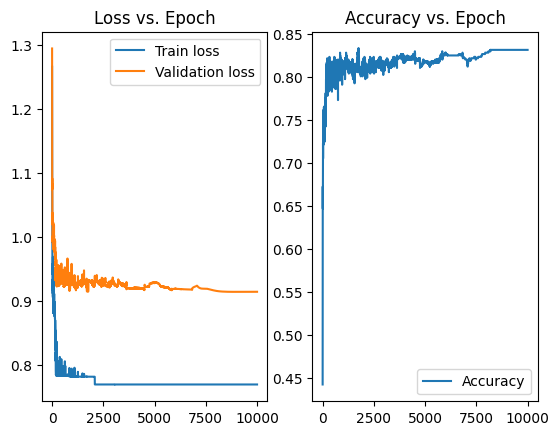

In [139]:
# Plot training and test losses and accuracies
plt.subplot(1, 2, 1)
plt.title("Loss vs. Epoch")
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title("Accuracy vs. Epoch")
plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.show()

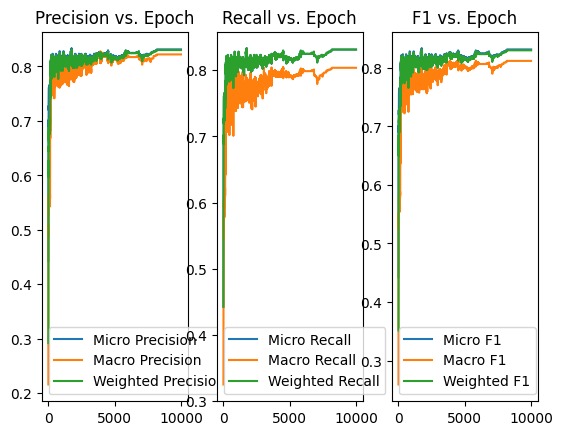

In [140]:
# Plot precisions, recalls, and f1s
plt.subplot(1, 3, 1)
plt.title("Precision vs. Epoch")
plt.plot(precisions[0], label='Micro Precision')
plt.plot(precisions[1], label='Macro Precision')
plt.plot(precisions[2], label='Weighted Precision')
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Recall vs. Epoch")
plt.plot(recalls[0], label='Micro Recall')
plt.plot(recalls[1], label='Macro Recall')
plt.plot(recalls[2], label='Weighted Recall')
plt.legend()

plt.subplot(1, 3, 3)
plt.title("F1 vs. Epoch")
plt.plot(f1s[0], label='Micro F1')
plt.plot(f1s[1], label='Macro F1')
plt.plot(f1s[2], label='Weighted F1')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Confusion matrix')

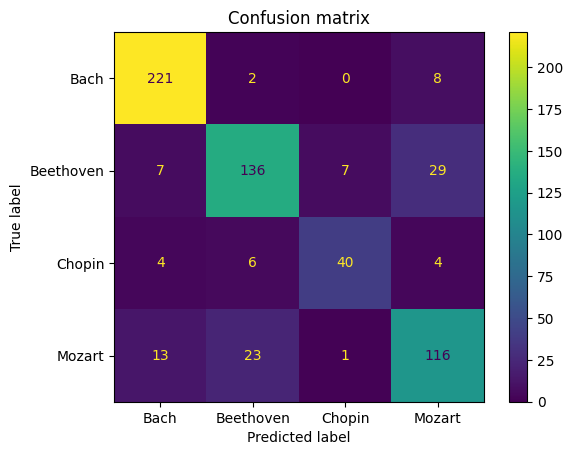

In [141]:
# Pretty confusion matrix
y_pred = torch.argmax(model(test_X), dim=1)
ConfusionMatrixDisplay.from_predictions(test_y.argmax(dim=1).cpu(), y_pred.cpu(), display_labels=COMPOSERS)
plt.title("Confusion matrix")